<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D2_DynamicNetworks/student/W3D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 2, Tutorial 2
# Neuronal Network Dynamics: Wilson-Cowan Model

__Content creators:__ Qinglong Gu, Songtin Li, Arvind Kumar, John Murray, Julijana Gjorgjieva 

__Content reviewers:__ Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Spiros Chavlis, Michael Waskom


---
# Tutorial Objectives
In the previous tutorial, you became familiar with a neuronal network consisting of only an excitatory population. Here, we extend the approach we used to include both excitatory and inhibitory neuronal populations in our network. A simple, yet powerful model to study the dynamics of two interacting populations of excitatory and inhibitory neurons, is the so-called **Wilson-Cowan** rate model, which will be the subject of this tutorial.

The objectives of this tutorial are to:

- Write the **Wilson-Cowan** equations for the firing rate dynamics of a 2D system composed of an excitatory (E) and an inhibitory (I) population of neurons
- Simulate the dynamics of the system, i.e., Wilson-Cowan model.
- Plot the frequency-current (F-I) curves for both populations (i.e., E and I).
- Visualize and inspect the behavior of the system using **phase plane analysis**, **vector fields**, and **nullclines**.

Bonus steps:

- Find and plot the **fixed points** of the Wilson-Cowan model.
- Investigate the stability of the Wilson-Cowan model by linearizing its dynamics and examining the **Jacobian matrix**.
- Learn how the Wilson-Cowan model can reach an oscillatory state.

Bonus steps (applications):
- Visualize the behavior of an Inhibition-stabilized network.
- Simulate working memory using the Wilson-Cowan model.

\\
Reference paper:

_[Wilson H and Cowan J (1972) Excitatory and inhibitory interactions in localized populations of model neurons. Biophysical Journal 12](https://doi.org/10.1016/S0006-3495(72)86068-5)_

---
# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt       # root-finding algorithm

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Helper functions


def default_pars(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau_E'] = 1.     # Timescale of the E population [ms]
  pars['a_E'] = 1.2      # Gain of the E population
  pars['theta_E'] = 2.8  # Threshold of the E population

  # Inhibitory parameters
  pars['tau_I'] = 2.0    # Timescale of the I population [ms]
  pars['a_I'] = 1.0      # Gain of the I population
  pars['theta_I'] = 4.0  # Threshold of the I population

  # Connection strength
  pars['wEE'] = 9.   # E to E
  pars['wEI'] = 4.   # I to E
  pars['wIE'] = 13.  # E to I
  pars['wII'] = 11.  # I to I

  # External input
  pars['I_ext_E'] = 0.
  pars['I_ext_I'] = 0.

  # simulation parameters
  pars['T'] = 50.        # Total duration of simulation [ms]
  pars['dt'] = .1        # Simulation time step [ms]
  pars['rE_init'] = 0.2  # Initial value of E
  pars['rI_init'] = 0.2  # Initial value of I

  # External parameters if any
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


def dF(x, a, theta):
  """
  Derivative of the population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  :  Derivative of the population activation function.
  """

  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx


def plot_FI_inverse(x, a, theta):
  f, ax = plt.subplots()
  ax.plot(x, F_inv(x, a=a, theta=theta))
  ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
  plt.figure()
  plt.plot(x, FI_exc, 'b', label='E population')
  plt.plot(x, FI_inh, 'r', label='I population')
  plt.legend(loc='lower right')
  plt.xlabel('x (a.u.)')
  plt.ylabel('F(x)')
  plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

  plt.figure()
  ax1 = plt.subplot(211)
  ax1.plot(pars['range_t'], rE1, 'b', label='E population')
  ax1.plot(pars['range_t'], rI1, 'r', label='I population')
  ax1.set_ylabel('Activity')
  ax1.legend(loc='best')

  ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
  ax2.plot(pars['range_t'], rE2, 'b', label='E population')
  ax2.plot(pars['range_t'], rI2, 'r', label='I population')
  ax2.set_xlabel('t (ms)')
  ax2.set_ylabel('Activity')
  ax2.legend(loc='best')

  plt.tight_layout()
  plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

  plt.figure()
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')
  plt.show()


def my_plot_nullcline(pars):
  Exc_null_rE = np.linspace(-0.01, 0.96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rI = np.linspace(-.01, 0.8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5):
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)

  n_skip = my_n_skip

  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars = pars.copy()
  pars['rE_init'], pars['rI_init'] = x_init[0], x_init[1]
  rE_tj, rI_tj = simulate_wc(**pars)

  plt.plot(rE_tj, rI_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Solve for I along the E_grid from dE/dt = 0.

  Expects:
  pars    : Parameter dictionary
  dx      : increment of initial values
  n       : n*n trjectories
  mylabel : label for legend

  Returns:
    figure of trajectory
  """
  pars = pars.copy()
  for ie in range(n):
    for ii in range(n):
      pars['rE_init'], pars['rI_init'] = dx * ie, dx * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      if (ie == n-1) & (ii == n-1):
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8, label=mylabel)
      else:
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8)

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def plot_complete_analysis(pars):
  plt.figure(figsize=(7.7, 6.))

  # plot example trajectories
  my_plot_trajectories(pars, 0.2, 6,
                       'Sample trajectories \nfor different init. conditions')
  my_plot_trajectory(pars, 'orange', [0.6, 0.8],
                     'Sample trajectory for \nlow activity')
  my_plot_trajectory(pars, 'm', [0.6, 0.6],
                     'Sample trajectory for \nhigh activity')

  # plot nullclines
  my_plot_nullcline(pars)

  # plot vector field
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')

  plt.legend(loc=[1.02, 0.57], handlelength=1)
  plt.show()


def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
           f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
           horizontalalignment='center', verticalalignment='bottom',
           rotation=rotation)

The helper functions included:

- Parameter dictionary: `default_pars(**kwargs)`. You can use:
  - `pars = default_pars()` to get all the parameters, and then you can execute `print(pars)` to check these parameters. 
  - `pars = default_pars(T=T_sim, dt=time_step)` to set a different simulation time and time step
  - After `pars = default_pars()`, use `par['New_para'] = value` to add a new parameter with its value
  - Pass to functions that accept individual parameters with `func(**pars)`
- F-I curve: `F(x, a, theta)`
- Derivative of the F-I curve: `dF(x, a, theta)`
- Plotting utilities

---
# Section 1: Wilson-Cowan model of excitatory and inhibitory populations


Video available at https://youtube.com/watch?v=GCpQmh45crM


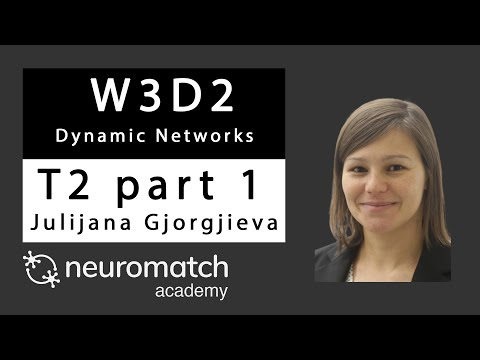

In [4]:
# @title Video 1: Phase analysis of the Wilson-Cowan E-I model
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="GCpQmh45crM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 1.1: Mathematical description of the WC model

Many of the rich dynamics recorded in the brain are generated by the interaction of excitatory and inhibitory subtype neurons. Here, similar to what we did in the previous tutorial, we will model two coupled populations of E and I neurons (**Wilson-Cowan** model). We can write two coupled differential equations, each representing the dynamics of the excitatory or inhibitory population:

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E)\\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I)    \qquad (1)
\end{align}

$r_E(t)$ represents the average activation (or firing rate) of the excitatory population at time $t$, and $r_I(t)$ the activation (or firing rate) of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of the dynamics of each population. Connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). The terms $w_{EI}$ and $w_{IE}$ represent connections from inhibitory to excitatory population and vice versa, respectively. The transfer functions (or F-I curves) $F_E(x;a_E,\theta_E)$ and $F_I(x;a_I,\theta_I)$ can be different for the excitatory and the inhibitory populations.


### Exercise 1: Plot out the F-I curves for the E and I populations 

Let's first plot out the F-I curves for the E and I populations using the function defined above with default parameter values.

In [5]:
pars = default_pars()
x = np.arange(0, 10, .1)

print(pars['a_E'], pars['theta_E'])
print(pars['a_I'], pars['theta_I'])

###################################################################
# TODO for students: compute and plot the F-I curve here          #
# Note: aE, thetaE, aI and theta_I are in the dictionray 'pars'   #
###################################################################

# Compute the F-I curve of the excitatory population
FI_exc = ...

# Compute the F-I curve of the inhibitory population
FI_inh = ...

# Uncomment when you fill the (...)
# plot_FI_EI(x, FI_exc, FI_inh)

1.2 2.8
1.0 4.0


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_b3a0ec15.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_b3a0ec15_3.png>



## Section 1.2: Simulation scheme for the Wilson-Cowan model

Equation $1$ can be integrated numerically. Using the Euler method, the dynamics of E and I populations can be simulated on a time-grid of stepsize $\Delta t$. The updates for the activity of the excitatory and the inhibitory populations can be written as:

\begin{align}
r_E[k+1] &= r_E[k] + \Delta r_E[k]\\
r_I[k+1] &= r_I[k] + \Delta r_I[k] 
\end{align}

with the increments

\begin{align}
\Delta r_E[k] &= \frac{\Delta t}{\tau_E}[-r_E[k] + F_E(w_{EE}r_E[k] -w_{EI}r_I[k] + I^{\text{ext}}_E[k];a_E,\theta_E)]\\
\Delta r_I[k] &= \frac{\Delta t}{\tau_I}[-r_I[k] + F_I(w_{IE}r_E[k] -w_{II}r_I[k] + I^{\text{ext}}_I[k];a_I,\theta_I)] 
\end{align}

### Exercise 2: Numerically integrate the Wilson-Cowan equations

In [7]:
def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):
    ########################################################################
    # TODO for students: compute drE and drI and remove the error
    raise NotImplementedError("Student exercise: compute the change in E/I")
    ########################################################################
    # Calculate the derivative of the E population
    drE = ...
    # Calculate the derivative of the I population
    drI = ...

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI


pars = default_pars()

# Here are two trajectories with close intial values
# Uncomment these lines to test your function
# rE1, rI1 = simulate_wc(**default_pars(rE_init=.32, rI_init=.15))
# rE2, rI2 = simulate_wc(**default_pars(rE_init=.33, rI_init=.15))
# my_test_plot(pars['range_t'], rE1, rI1, rE2, rI2)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_af0bd722.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_af0bd722_0.png>



The two plots above show the temporal evolution of excitatory ($r_E$, blue) and inhibitory ($r_I$, red) activity for two different sets of initial conditions.

### Interactive Demo: population trajectories with different initial values
In this interactive demo, we will simulate the Wilson-Cowan model and plot the trajectories of each population. What happens to the E and I population trajectories with different initial conditions?



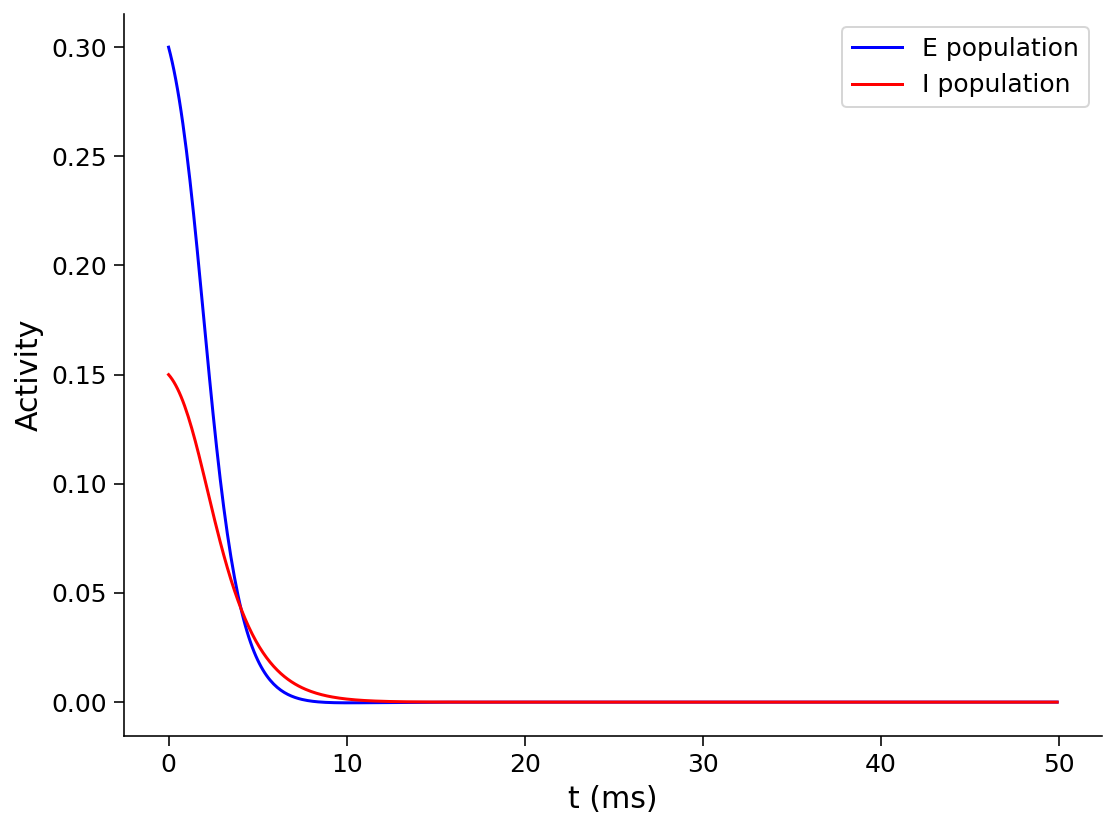

In [9]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_EI_diffinitial(rE_init=0.0):

  pars = default_pars(rE_init=rE_init, rI_init=.15)
  rE, rI = simulate_wc(**pars)

  plt.figure()
  plt.plot(pars['range_t'], rE, 'b', label='E population')
  plt.plot(pars['range_t'], rI, 'r', label='I population')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.show()


_ = widgets.interact(plot_EI_diffinitial, rE_init=(0.30, 0.35, .01))

## Think!
It is evident that the steady states of the neuronal response can be different when different initial states are chosen. Why is that? 

We will discuss this in the next section but try to think about it first.

---
# Section 2: Phase plane analysis
Just like we used a graphical method to study the dynamics of a 1-D system in the previous tutorial, here we will learn a  graphical approach called **phase plane analysis** to study the dynamics of a 2-D system like the Wilson-Cowan model. 

So far, we have plotted the activities of the two populations as a function of time, i.e., in the `Activity-t` plane, either the $(t, r_E(t))$ plane or the $(t, r_I(t))$ one. Instead, we can plot the two activities $r_E(t)$ and $r_I(t)$ against each other at any time point $t$. This characterization in the `rI-rE` plane $(r_I(t), r_E(t))$ is called the **phase plane**. Each line in the phase plane indicates how both $r_E$ and $r_I$ evolve with time.

Video available at https://youtube.com/watch?v=V2SBAK2Xf8Y


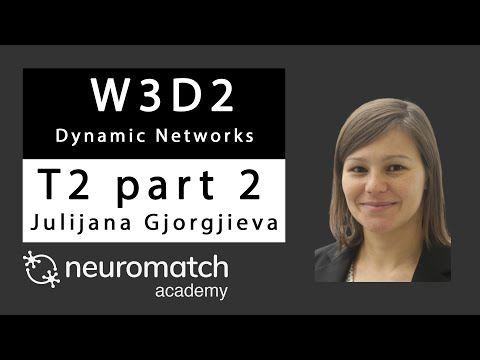

In [10]:
# @title Video 2: Nullclines and Vector Fields
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="V2SBAK2Xf8Y", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Interactive Demo: From the Activity - time plane to the **$r_I$ - $r_E$** phase plane

In this demo, we will visualize the system dynamics using both the `Activity-time` and the `(rE, rI)` phase plane. The circles indicate the activities at a given time $t$, while the lines represent the evolution of the system for the entire duration of the simulation.

Move the time slider to better understand how the top plot relates to the bottom plot. Does the bottom plot have explicit information about time? What information does it give us?

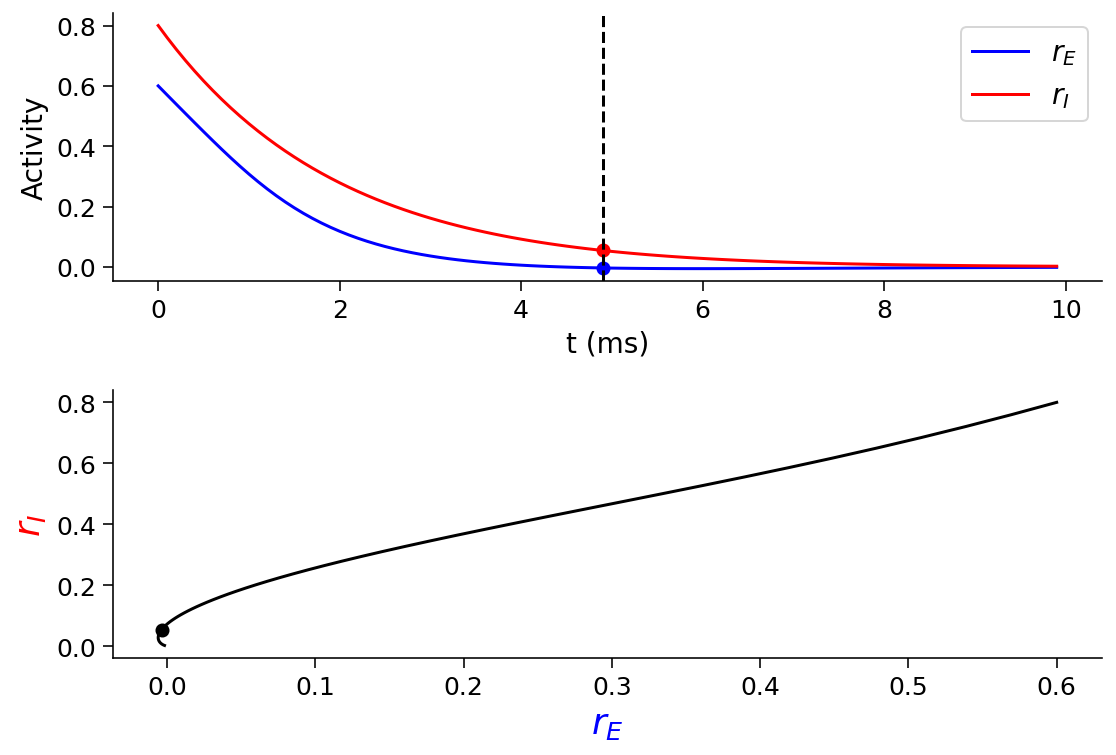

In [11]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

pars = default_pars(T=10, rE_init=0.6, rI_init=0.8)
rE, rI = simulate_wc(**pars)


def plot_activity_phase(n_t):
  plt.figure(figsize=(8, 5.5))
  plt.subplot(211)
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.plot(pars['range_t'][n_t], rE[n_t], 'bo')
  plt.plot(pars['range_t'][n_t], rI[n_t], 'ro')
  plt.axvline(pars['range_t'][n_t], 0, 1, color='k', ls='--')
  plt.xlabel('t (ms)', fontsize=14)
  plt.ylabel('Activity', fontsize=14)
  plt.legend(loc='best', fontsize=14)

  plt.subplot(212)
  plt.plot(rE, rI, 'k')
  plt.plot(rE[n_t], rI[n_t], 'ko')
  plt.xlabel(r'$r_E$', fontsize=18, color='b')
  plt.ylabel(r'$r_I$', fontsize=18, color='r')

  plt.tight_layout()
  plt.show()


_ = widgets.interact(plot_activity_phase, n_t=(0, len(pars['range_t']) - 1, 1))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_719e1807.py)



## Section 2.1: Nullclines of the Wilson-Cowan Equations

An important concept in the phase plane analysis is the "nullcline" which is defined as the set of points in the phase plane where the activity of one population (but not necessarily the other) does not change.

In other words, the $E$ and $I$ nullclines of Equation $(1)$ are defined as the points where $\displaystyle{\frac{dr_E}{dt}}=0$, for the excitatory nullcline, or $\displaystyle\frac{dr_I}{dt}=0$ for the inhibitory nullcline. That is:

\begin{align}
-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E) &= 0  \qquad (2)\\[1mm]
-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I) &= 0    \qquad (3)
\end{align}

### Exercise 3: Compute the nullclines of the Wilson-Cowan model

In the next exercise, we will compute and plot the nullclines of the E and I population.


Along the nullcline of excitatory population Equation $2$, you can calculate the inhibitory activity by rewriting Equation $2$ into

\begin{align}
r_I = \frac{1}{w_{EI}}\big{[}w_{EE}r_E - F_E^{-1}(r_E; a_E,\theta_E) + I^{\text{ext}}_E \big{]}. \qquad(4)
\end{align}

where $F_E^{-1}(r_E; a_E,\theta_E)$ is the inverse of the excitatory transfer function (defined below). Equation $4$ defines the $r_E$ nullcline.

Along the nullcline of inhibitory population Equation $3$, you can calculate the inhibitory activity by rewriting Equation $3$ into 
\begin{align}
r_E = \frac{1}{w_{IE}} \big{[} w_{II}r_I + F_I^{-1}(r_I;a_I,\theta_I) - I^{\text{ext}}_I \big{]}.  \qquad (5)  
\end{align}

shere $F_I^{-1}(r_I; a_I,\theta_I)$ is the inverse of the inhibitory transfer function (defined below). Equation $5$ defines the $I$ nullcline.

Note that, when computing the nullclines with Equations 4-5, we also need to calculate the inverse of the transfer functions. \\

The inverse of the sigmoid shaped **f-I** function that we have been using is:

$$F^{-1}(x; a, \theta) = -\frac{1}{a} \ln \left[ \frac{1}{x + \displaystyle \frac{1}{1+\text{e}^{a\theta}}} - 1 \right] + \theta \qquad (6)$$

The first step is to implement the inverse transfer function:

In [13]:
def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  #########################################################################
  # TODO for students: compute F_inverse
  raise NotImplementedError("Student exercise: compute the inverse of F(x)")
  #########################################################################
  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = ...  

  return F_inverse


pars = default_pars()
x = np.linspace(1e-6, 1, 100)

# Uncomment the next line to test your function
# plot_FI_inverse(x, a=1, theta=3)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_937a4040.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=413 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_937a4040_1.png>



Now you can compute the nullclines, using Equations 4-5:

In [15]:
def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  #########################################################################
  # TODO for students: compute rI for rE nullcline and disable the error
  raise NotImplementedError("Student exercise: compute the E nullcline")
  #########################################################################
  # calculate rI for E nullclines on rI
  rI = ...

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  #########################################################################
  # TODO for students: compute rI for rE nullcline and disable the error
  raise NotImplementedError("Student exercise: compute the I nullcline")
  #########################################################################
  # calculate rE for I nullclines on rI
  rE = ...

  return rE


pars = default_pars()
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Uncomment these lines to test your functions
# Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
# Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

# plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_2366ea57.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_2366ea57_0.png>



Note that by definition along the blue line in the phase-plane spanned by $r_E, r_I$, $\displaystyle{\frac{dr_E(t)}{dt}} = 0$, therefore, it is called a nullcline. 

That is, the blue nullcline divides the phase-plane spanned by $r_E, r_I$ into two regions: on one side of the nullcline $\displaystyle{\frac{dr_E(t)}{dt}} > 0$ and on the other side $\displaystyle{\frac{dr_E(t)}{dt}} < 0$.

The same is true for the red line along which $\displaystyle{\frac{dr_I(t)}{dt}} = 0$. That is, the red nullcline divides the phase-plane spanned by $r_E, r_I$ into two regions: on one side of the nullcline $\displaystyle{\frac{dr_I(t)}{dt}} > 0$ and on the other side $\displaystyle{\frac{dr_I(t)}{dt}} < 0$.


## Section 2.2: Vector field

How can the phase plane and the nullcline curves help us understand the behavior of the Wilson-Cowan model? 

The activities of the $E$ and $I$ populations $r_E(t)$ and $r_I(t)$ at each time point $t$ correspond to a single point in the phase plane, with coordinates $(r_E(t),r_I(t))$. Therefore, the time-dependent trajectory of the system can be described as a continuous curve in the phase plane, and the tangent vector to the trajectory, which is defined as the vector $\bigg{(}\displaystyle{\frac{dr_E(t)}{dt},\frac{dr_I(t)}{dt}}\bigg{)}$, indicates the direction towards which the activity is evolving and how fast is the activity changing along each axis. In fact, for each point $(E,I)$ in the phase plane, we can compute the tangent vector $\bigg{(}\displaystyle{\frac{dr_E}{dt},\frac{dr_I}{dt}}\bigg{)}$, which  indicates the behavior of the system when it traverses that point. 

The map of tangent vectors in the phase plane is called **vector field**. The behavior of any trajectory in the phase plane is determined by i) the initial conditions $(r_E(0),r_I(0))$, and ii) the vector field $\bigg{(}\displaystyle{\frac{dr_E(t)}{dt},\frac{dr_I(t)}{dt}}\bigg{)}$.

In general, the value of the vector field at a particular point in the phase plane is represented by an arrow. The orientation and the size of the arrow reflect the direction and the norm of the vector, respectively.

### Exercise 4: Compute and plot the vector field $\displaystyle{\Big{(}\frac{dr_E}{dt}, \frac{dr_I}{dt} \Big{)}}$

Note that

\begin{align}
\frac{dr_E}{dt} &= [-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E)]\frac{1}{\tau_E}\\
\frac{dr_I}{dt} &= [-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I)]\frac{1}{\tau_I}    
\end{align}

In [17]:
def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""
  ######################################################################
  # TODO for students: compute drEdt and drIdt and disable the error
  raise NotImplementedError("Student exercise: compute the vector field")
  ######################################################################
  # Compute the derivative of rE
  drEdt = ...
  # Compute the derivative of rI
  drIdt = ...

  return drEdt, drIdt


# Uncomment below to test your function
# plot_complete_analysis(default_pars())

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_5a629797.py)

*Example output:*

<img alt='Solution hint' align='left' width=535 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_5a629797_0.png>




The last phase plane plot shows us that: 
- Trajectories seem to follow the direction of the vector field
- Different trajectories eventually always reach one of two points depending on the initial conditions. 
- The two points where the trajectories converge are the intersection of the two nullcline curves. 

## Think! 

There are, in total, three intersection points, meaning that the system has three fixed points.

- One of the fixed points (the one in the middle) is never the final state of a trajectory. Why is that? 
- Why the arrows tend to get smaller as they approach the fixed points?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_21fedd8a.py)



---
# Summary

Congratulations! You have finished the second day of the last week of the neuromatch academy! Here, you learned how to simulate a rate based model consisting of excitatory and inhibitory population of neurons.

In the last tutorial on dynamical neuronal networks you learned to:
- Implement and simulate a 2D system composed of an E and an I population of neurons using the **Wilson-Cowan** model
- Plot the frequency-current (F-I) curves for both populations
- Examine the behavior of the system using phase **plane analysis**, **vector fields**, and **nullclines**.

Do you have more time? Have you finished early? We have more fun material for you!

Below are some, more advanced concepts on dynamical systems:

- You will learn how to find the fixed points on such a system, and to investigate its stability by linearizing its dynamics and examining the **Jacobian matrix**.
- You will see identify conditions under which the Wilson-Cowan model can exhibit oscillations.

If you need even more, there are two applications of the Wilson-Cowan model:

- Visualization of an Inhibition-stabilized network
- Simulation of working memory

---
# Bonus 1: Fixed points, stability analysis, and limit cycles in the Wilson-Cowan model

Video available at https://youtube.com/watch?v=jIx26iQ69ps


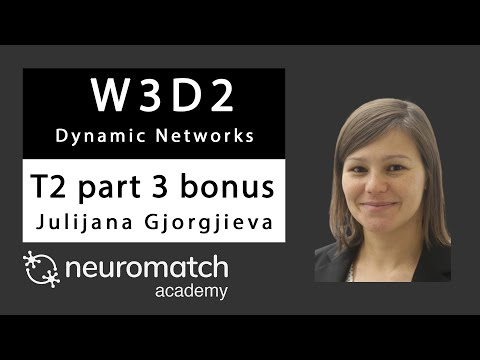

In [20]:
# @title Video 3: Fixed points and their stability
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="jIx26iQ69ps", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Fixed Points of the E/I system

Clearly, the intersection points of the two nullcline curves are the fixed points of the Wilson-Cowan model in Equation $(1)$. 

In the next exercise, we will find the coordinate of all fixed points for a given set of parameters.

We'll make use of two functions, similar to ones we saw in the previous tutorial, which use a root-finding algorithm to find the fixed points of the system with Excitatory and Inhibitory populations.

In [21]:
# @markdown *Execute the cell to define `my_fp` and `check_fp`*

def my_fp(pars, rE_init, rI_init):
  """
  Use opt.root function to solve Equations (2)-(3) from initial values
  """

  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI']
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

  # define the right hand of wilson-cowan equations
  def my_WCr(x):

    rE, rI = x
    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I
    y = np.array([drEdt, drIdt])

    return y

  x0 = np.array([rE_init, rI_init])
  x_fp = opt.root(my_WCr, x0).x

  return x_fp


def check_fp(pars, x_fp, mytol=1e-6):
  """
  Verify (drE/dt)^2 + (drI/dt)^2< mytol

  Args:
    pars    : Parameter dictionary
    fp      : value of fixed point
    mytol   : tolerance, default as 10^{-6}

  Returns :
    Whether it is a correct fixed point: True/False
  """

  drEdt, drIdt = EIderivs(x_fp[0], x_fp[1], **pars)

  return drEdt**2 + drIdt**2 < mytol

### Exercise 5: Find the fixed points of the Wilson-Cowan model

From the above nullclines, we notice that the system features  three fixed points with the parameters we used. To find their coordinates, we need to choose proper initial value to give to the `opt.root` function inside of the function `my_fp` we just defined, since the algorithm can only find fixed points in the vicinity of the initial value. 

In this exercise, you will use the function `my_fp` to find each of the fixed points by varying the initial values. Note that you can choose the values near the intersections of the nullclines as the initial values to calculate the fixed points.

In [22]:
pars = default_pars()

######################################################################
# TODO: Provide initial values to calculate the fixed points
# Check if x_fp's are the correct with the function check_fp(x_fp)
# Hint: vary different initial values to find the correct fixed points                                #
######################################################################

# my_plot_nullcline(pars)

# Find the first fixed point
# x_fp_1 = my_fp(pars, ..., ...)
# if check_fp(pars, x_fp_1):
#   plot_fp(x_fp_1)

# Find the second fixed point
# x_fp_2 = my_fp(pars, ..., ...)
# if check_fp(pars, x_fp_2):
#   plot_fp(x_fp_2)

# Find the third fixed point
# x_fp_3 = my_fp(pars, ..., ...)
# if check_fp(pars, x_fp_3):
#   plot_fp(x_fp_3)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_0dd7ba5a.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_0dd7ba5a_0.png>



## Stability of a fixed point and eigenvalues of the Jacobian Matrix

First, let's first rewrite the system $1$ as:

\begin{align}
&\frac{dr_E}{dt} = G_E(r_E,r_I)\\[0.5mm]
&\frac{dr_I}{dt} = G_I(r_E,r_I)
\end{align}
where

\begin{align}
&G_E(r_E,r_I) = \frac{1}{\tau_E} [-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a,\theta)]\\[1mm]
&G_I(r_E,r_I) = \frac{1}{\tau_I} [-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a,\theta)]
\end{align}

By definition, $\displaystyle\frac{dr_E}{dt}=0$ and $\displaystyle\frac{dr_I}{dt}=0$ at each fixed point. Therefore, if the initial state is exactly at the fixed point, the state of the system will not change as time evolves. 

However, if the initial state deviates slightly from the fixed point, there are two possibilities
the trajectory will be attracted back to the 

1.   The trajectory will be attracted back to the fixed point
2.   The trajectory will diverge from the fixed point. 

These two possibilities define the type of fixed point, i.e., stable or unstable. Similar to the 1D system studied in the previous tutorial, the stability of a fixed point $(r_E^*, r_I^*)$ can be determined by linearizing the dynamics of the system (can you figure out how?). The linearization will yield a matrix of first-order derivatives called the Jacobian matrix:

 \begin{equation}
   J=
  \left[ {\begin{array}{cc}
   \displaystyle{\frac{\partial}{\partial r_E}}G_E(r_E^*, r_I^*) & \displaystyle{\frac{\partial}{\partial r_I}}G_E(r_E^*, r_I^*)\\[1mm]
   \displaystyle\frac{\partial}{\partial r_E} G_I(r_E^*, r_I^*) & \displaystyle\frac{\partial}{\partial r_I}G_I(r_E^*, r_I^*) \\
  \end{array} } \right] \quad (7)
\end{equation}

\\

The eigenvalues of the Jacobian matrix calculated at the fixed point will determine whether it is a stable or unstable fixed point.

\\

We can now compute the derivatives needed to build the Jacobian matrix. Using the chain and product rules the derivatives for the excitatory population are given by:

\\

\begin{align}
&\frac{\partial}{\partial r_E} G_E(r_E^*, r_I^*) = \frac{1}{\tau_E} [-1 + w_{EE} F_E'(w_{EE}r_E^* -w_{EI}r_I^* +  I^{\text{ext}}_E;\alpha_E, \theta_E)] \\[1mm]
&\frac{\partial}{\partial r_I} G_E(r_E^*, r_I^*)= \frac{1}{\tau_E} [-w_{EI} F_E'(w_{EE}r_E^* -w_{EI}r_I^* +  I^{\text{ext}}_E;\alpha_E, \theta_E)]
\end{align}

\\

The same applies to the inhibitory population. 

### Exercise 6: Compute the Jacobian Matrix for the Wilson-Cowan model

Here, you can use `dF(x,a,theta)` defined in the `Helper functions` to calculate the derivative of the F-I curve.

In [24]:
def get_eig_Jacobian(fp,
                     tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
                     tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
  # Initialization
  rE, rI = fp
  J = np.zeros((2, 2))

  ###########################################################################
  # TODO for students: compute J and disable the error
  raise NotImplementedError("Student excercise: compute the Jacobian matrix")
  ###########################################################################
  # Compute the four elements of the Jacobian matrix
  J[0, 0] = ...
  J[0, 1] = ...
  J[1, 0] = ...
  J[1, 1] = ...

  # Compute and return the eigenvalues
  evals = np.linalg.eig(J)[0]
  return evals


# Uncomment below to test your function when you get the correct fixed point
# eig_1 = get_eig_Jacobian(x_fp_1, **pars)
# eig_2 = get_eig_Jacobian(x_fp_2, **pars)
# eig_3 = get_eig_Jacobian(x_fp_3, **pars)

# print(eig_1, 'Stable point')
# print(eig_2, 'Unstable point')
# print(eig_3, 'Stable point')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_a9d2aba4.py)



As is evident, the stable fixed points correspond to the negative eigenvalues, while unstable point corresponds to at least one positive eigenvalue.

The sign of the eigenvalues is determined by the connectivity (interaction) between excitatory and inhibitory populations. 

Below we investigate the effect of $w_{EE}$ on the nullclines and the eigenvalues of the dynamical system. 

\* _Critical change is referred to as **pitchfork bifurcation**_. 

## Effect of `wEE` on the nullclines and the eigenvalues

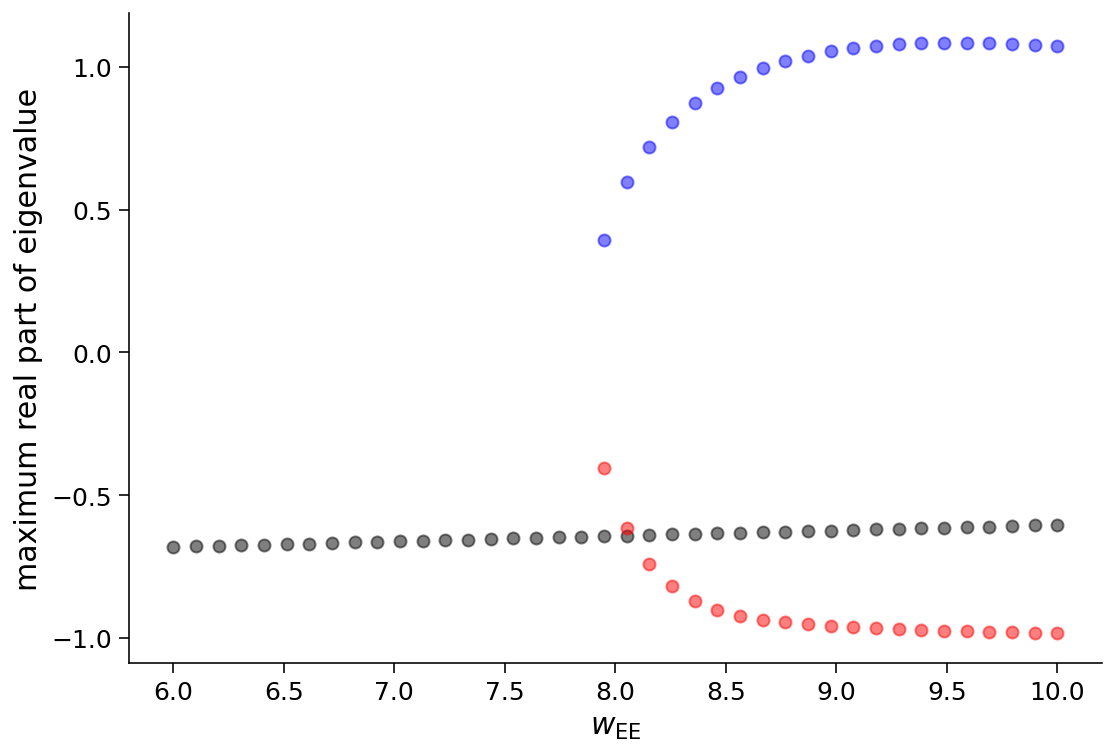

In [26]:
# @title

# @markdown Make sure you execute this cell to see the plot!

eig_1_M = []
eig_2_M = []
eig_3_M = []
pars = default_pars()
wEE_grid = np.linspace(6, 10, 40)
my_thre = 7.9
for wEE in wEE_grid:
  x_fp_1 = [0., 0.]
  x_fp_2 = [.4, .1]
  x_fp_3 = [.8, .1]
  pars['wEE'] = wEE
  if wEE < my_thre:
    x_fp_1 = my_fp(pars, x_fp_1[0], x_fp_1[1])
    eig_1 = get_eig_Jacobian(x_fp_1, **pars)
    eig_1_M.append(np.max(np.real(eig_1)))
  else:
    x_fp_1 = my_fp(pars, x_fp_1[0], x_fp_1[1])
    eig_1 = get_eig_Jacobian(x_fp_1, **pars)
    eig_1_M.append(np.max(np.real(eig_1)))

    x_fp_2 = my_fp(pars, x_fp_2[0], x_fp_2[1])
    eig_2 = get_eig_Jacobian(x_fp_2, **pars)
    eig_2_M.append(np.max(np.real(eig_2)))

    x_fp_3 = my_fp(pars, x_fp_3[0], x_fp_3[1])
    eig_3 = get_eig_Jacobian(x_fp_3, **pars)
    eig_3_M.append(np.max(np.real(eig_3)))

eig_1_M = np.array(eig_1_M)
eig_2_M = np.array(eig_2_M)
eig_3_M = np.array(eig_3_M)

plt.figure(figsize=(8, 5.5))
plt.plot(wEE_grid, eig_1_M, 'ko', alpha=0.5)
plt.plot(wEE_grid[wEE_grid >= my_thre], eig_2_M, 'bo', alpha=0.5)
plt.plot(wEE_grid[wEE_grid >= my_thre], eig_3_M, 'ro', alpha=0.5)
plt.xlabel(r'$w_{\mathrm{EE}}$')
plt.ylabel('maximum real part of eigenvalue')
plt.show()

## Interactive Demo: Nullclines position in the phase plane changes with parameter values

In this interactive widget, we will explore how the nullclines move for different values of the parameter $w_{EE}$.

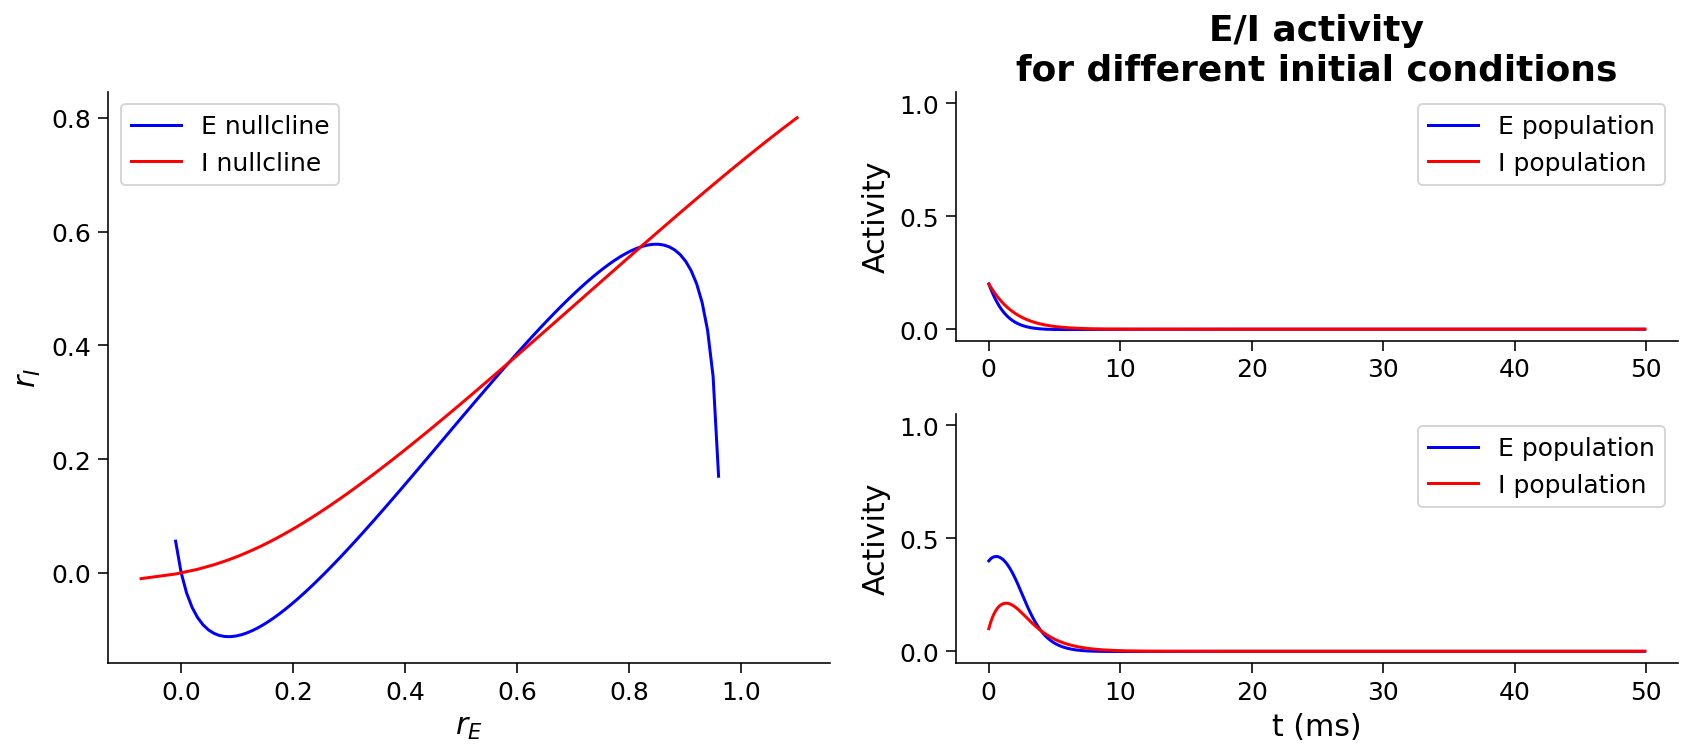

In [27]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_nullcline_diffwEE(wEE):
  """
    plot nullclines for different values of wEE
  """

  pars = default_pars(wEE=wEE)

  # plot the E, I nullclines
  Exc_null_rE = np.linspace(-0.01, .96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)

  Inh_null_rI = np.linspace(-.01, .8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12, 5.5))
  plt.subplot(121)
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')

  plt.subplot(222)
  pars['rE_init'], pars['rI_init'] = 0.2, 0.2
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I population', clip_on=False)
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)
  plt.title('E/I activity\nfor different initial conditions',
            fontweight='bold')

  plt.subplot(224)
  pars['rE_init'], pars['rI_init'] = 0.4, 0.1
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I population', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)

  plt.tight_layout()
  plt.show()


_ = widgets.interact(plot_nullcline_diffwEE, wEE=(6., 10., .01))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_9e243de6.py)



We can also investigate the effect of different $w_{EI}$, $w_{IE}$, $w_{II}$, $\tau_{E}$, $\tau_{I}$, and $I_{E}^{\text{ext}}$ on the stability of fixed points. In addition, we can also consider the perturbation of the parameters of the gain curve $F(\cdot)$.

## Limit cycle - Oscillations

For some values of interaction terms ($w_{EE}, w_{IE}, w_{EI}, w_{II}$ the eigenvalues can become complex. When at least one pair of eigenvalues is complex, oscillations arise. 
The stability of oscillations is determined by the real part of the eigenvalues (+ve real part oscillations will grow, -ve real part oscillations will die out). The size of the complex part determines the frequency of oscillations. 

For instance, if we use a different set of parameters, $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, and $I_{E}^{\text{ext}}=0.8$, then we shall observe that the E and I population activity start to oscillate! Please execute the cell below to check the oscillatory behavior. 

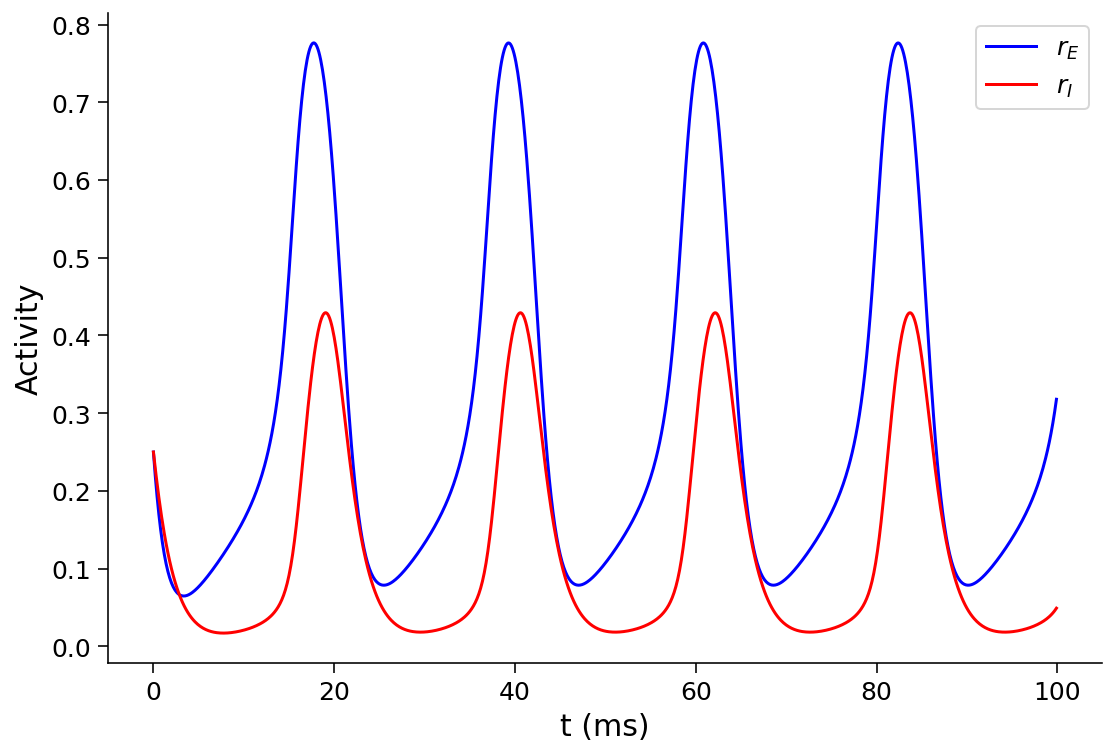

In [29]:
# @title

# @markdown Make sure you execute this cell to see the oscillations!

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['rE_init'], pars['rI_init'] = 0.25, 0.25

rE, rI = simulate_wc(**pars)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
plt.xlabel('t (ms)')
plt.ylabel('Activity')
plt.legend(loc='best')
plt.show()

### Exercise 7: Plot the phase plane

We can also understand the oscillations of the population behavior using the phase plane. By plotting a set of trajectories with different initial states, we can see that these trajectories will move in a circle instead of converging to a fixed point. This circle is called "limit cycle" and shows the periodic oscillations of the $E$ and $I$ population behavior under some conditions.

Try to plot the phase plane using the previously defined functions.

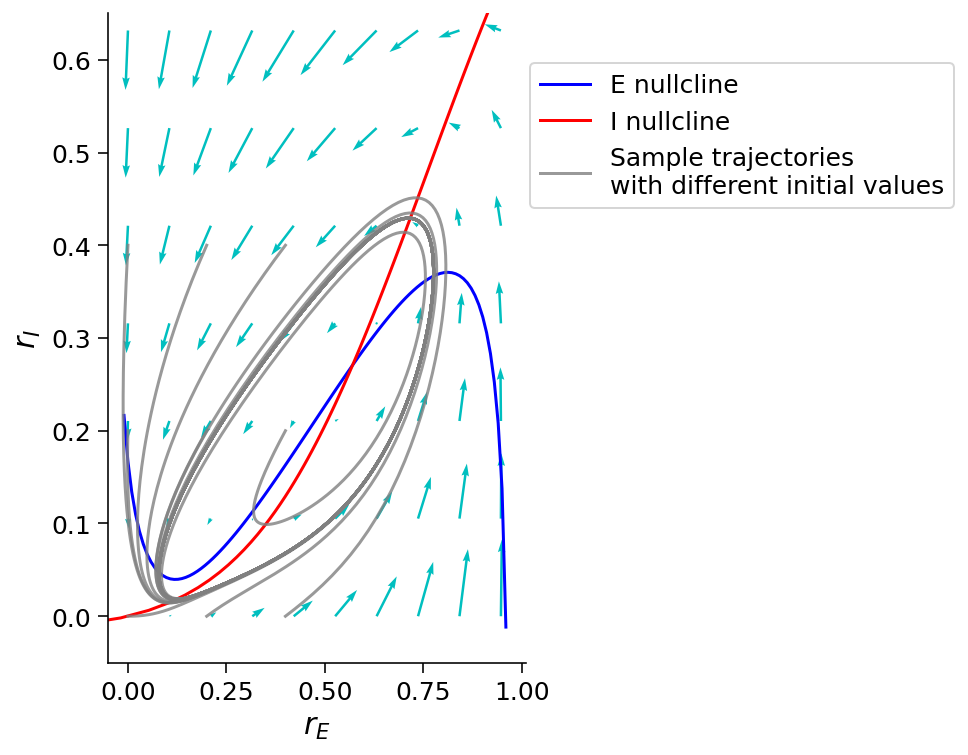

In [30]:
pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8

plt.figure(figsize=(7, 5.5))
my_plot_nullcline(pars)
###############################################################################
# TODO for students: plot phase plane: nullclines, trajectories, fixed point  #
###############################################################################

# Find the correct fixed point
# x_fp_1 = my_fp(pars, ..., ...)
# if check_fp(pars, x_fp_1):
#   plot_fp(x_fp_1, position=(0, 0), rotation=40)


my_plot_trajectories(pars, 0.2, 3,
                     'Sample trajectories \nwith different initial values')
my_plot_vector(pars)

plt.legend(loc=[1.01, 0.7])
plt.xlim(-0.05, 1.01)
plt.ylim(-0.05, 0.65)
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_03c5c8dd.py)

*Example output:*

<img alt='Solution hint' align='left' width=486 height=380 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_03c5c8dd_0.png>



## Interactive Demo: Limit cycle and oscillations.

From the above examples, the change of model parameters changes the shape of the nullclines and, accordingly, the behavior of the $E$ and $I$ populations from steady fixed points to oscillations. However, the shape of the nullclines is unable to fully determine the behavior of the network. The vector field also matters. To demonstrate this, here, we will investigate the effect of time constants on the population behavior. By changing the inhibitory time constant $\tau_I$, the nullclines do not change, but the network behavior changes substantially from steady state to oscillations with different frequencies. 

Such a dramatic change in the system behavior is referred to as a **bifurcation**. 

\\
Please execute the code below to check this out.

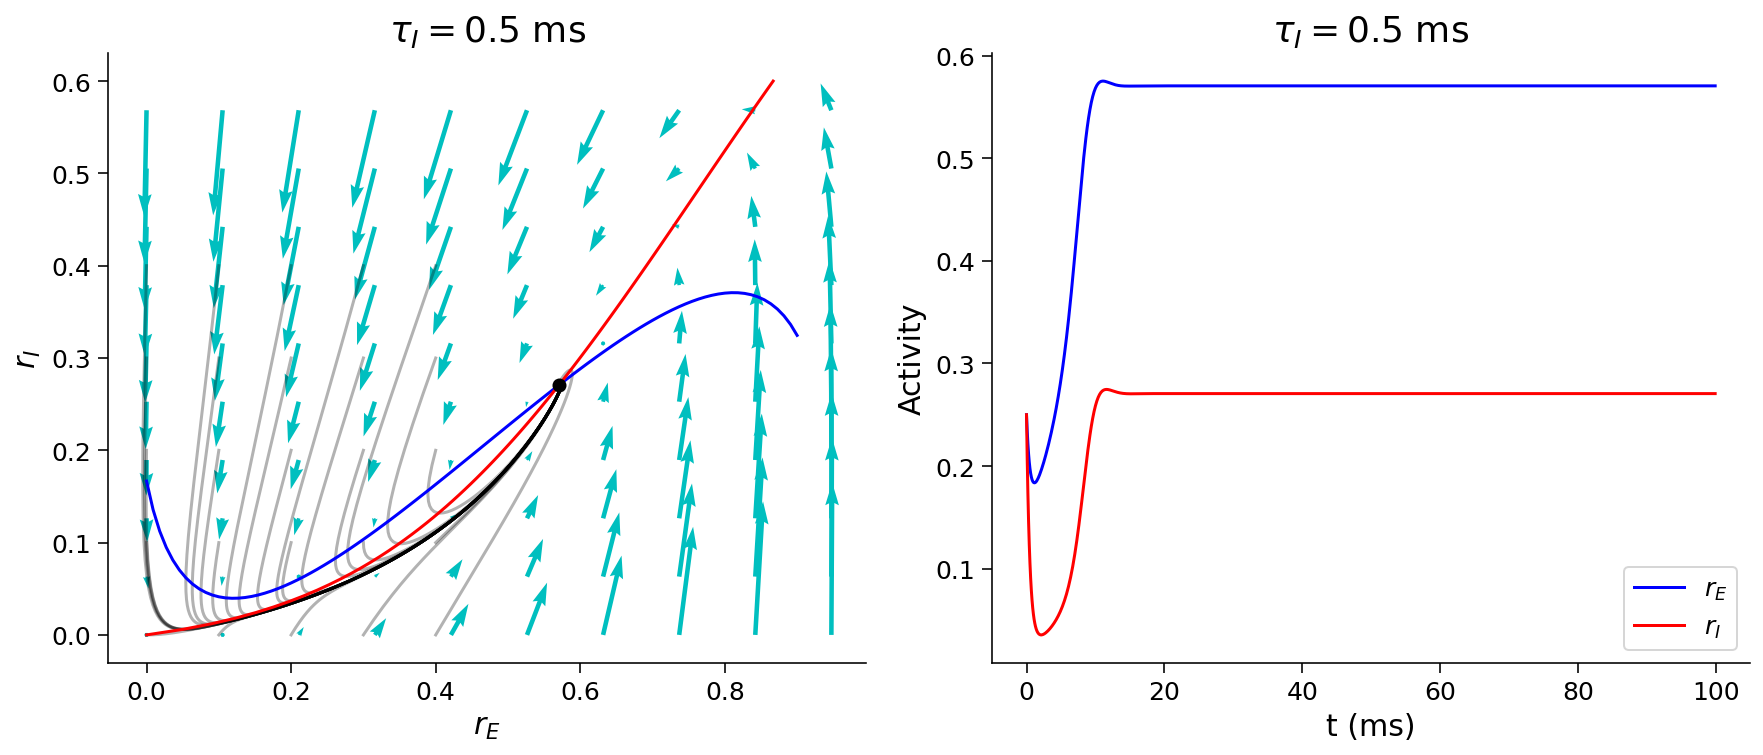

In [32]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def time_constant_effect(tau_i=0.5):

  pars = default_pars(T=100.)
  pars['wEE'], pars['wEI'] = 6.4, 4.8
  pars['wIE'], pars['wII'] = 6.0, 1.2
  pars['I_ext_E'] = 0.8

  pars['tau_I'] = tau_i

  Exc_null_rE = np.linspace(0.0, .9, 100)
  Inh_null_rI = np.linspace(0.0, .6, 100)

  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12.5, 5.5))

  plt.subplot(121)  # nullclines
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline', zorder=2)
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline', zorder=2)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')

  # fixed point
  x_fp_1 = my_fp(pars, 0.5, 0.5)
  plt.plot(x_fp_1[0], x_fp_1[1], 'ko', zorder=2)

  eig_1 = get_eig_Jacobian(x_fp_1, **pars)

  # trajectories
  for ie in range(5):
    for ii in range(5):
      pars['rE_init'], pars['rI_init'] = 0.1 * ie, 0.1 * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      plt.plot(rE_tj, rI_tj, 'k', alpha=0.3, zorder=1)

  # vector field
  EI_grid_E = np.linspace(0., 1.0, 20)
  EI_grid_I = np.linspace(0., 0.6, 20)
  rE, rI = np.meshgrid(EI_grid_E, EI_grid_I)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
              drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
              angles='xy', scale_units='xy', scale=10, facecolor='c')
  plt.title(r'$\tau_I=$'+'%.1f ms' % tau_i)

  plt.subplot(122)  # sample E/I trajectories
  pars['rE_init'], pars['rI_init'] = 0.25, 0.25
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.title(r'$\tau_I=$'+'%.1f ms' % tau_i)
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()


_ = widgets.interact(time_constant_effect, tau_i=(0.2, 3, .1))

Both $\tau_E$ and $\tau_I$ feature in the Jacobian of the two population network (eq 7). So here is seems that the by increasing $\tau_I$ the eigenvalues corresponding to the stable fixed point are becoming complex.

Intuitively, when $\tau_I$ is smaller, inhibitory activity changes faster than excitatory activity. As inhibition exceeds above a certain value, high inhibition inhibits excitatory population but that in turns means that inhibitory population gets smaller input (from the exc. connection). So inhibition decreases rapidly. But this means that excitation recovers -- and so on ...

---
# Bonus 2: Inhibition-stabilized network (ISN)

As described above, one can obtain the linear approximation around the fixed point as 

 \begin{equation}
   \frac{d}{dr}  \vec{R}=
  \left[ {\begin{array}{cc}
   \displaystyle{\frac{\partial G_E}{\partial r_E}} & \displaystyle{\frac{\partial G_E}{\partial r_I}}\\[1mm]
   \displaystyle\frac{\partial G_I}{\partial r_E} & \displaystyle\frac{\partial G_I}{\partial r_I} \\
  \end{array} } \right] \vec{R},
\end{equation}

\\


where $\vec{R} = [r_E, r_I]^{\rm T}$ is the vector of the E/I activity.

Let's direct our attention to the excitatory subpopulation which follows:

\\


\begin{equation}
\frac{dr_E}{dt} = \frac{\partial G_E}{\partial r_E}\cdot r_E + \frac{\partial G_E}{\partial r_I} \cdot r_I
\end{equation}

\\

Recall that, around fixed point $(r_E^*, r_I^*)$:

\\

\begin{align}
&\frac{\partial}{\partial r_E}G_E(r_E^*, r_I^*) = \frac{1}{\tau_E} [-1 + w_{EE} F'_{E}(w_{EE}r_E^* -w_{EI}r_I^* + I^{\text{ext}}_E; \alpha_E, \theta_E)] \qquad (8)\\[1mm]
&\frac{\partial}{\partial r_I}G_E(r_E^*, r_I^*) = \frac{1}{\tau_E} [-w_{EI} F'_{E}(w_{EE}r_E^* -w_{EI}r_I^* + I^{\text{ext}}_E; \alpha_E, \theta_E)] \qquad (9)\\[1mm]
&\frac{\partial}{\partial r_E}G_I(r_E^*, r_I^*) = \frac{1}{\tau_I} [w_{IE} F'_{I}(w_{IE}r_E^* -w_{II}r_I^* + I^{\text{ext}}_I; \alpha_I, \theta_I)] \qquad (10)\\[1mm]
&\frac{\partial}{\partial r_I}G_I(r_E^*, r_I^*) = \frac{1}{\tau_I} [-1-w_{II} F'_{I}(w_{IE}r_E^* -w_{II}r_I^* + I^{\text{ext}}_I; \alpha_I, \theta_I)] \qquad (11)
\end{align} \\


From Equation. (8), it is clear that $\displaystyle{\frac{\partial G_E}{\partial r_I}}$ is negative since the $\displaystyle{\frac{dF}{dx}}$ is always positive. It can be understood by that the recurrent inhibition from the inhibitory activity ($I$) can reduce the excitatory ($E$) activity. However, as described above, $\displaystyle{\frac{\partial G_E}{\partial r_E}}$ has negative terms related to the "leak" effect, and positive term related to the recurrent excitation. Therefore, it leads to two different regimes:

- $\displaystyle{\frac{\partial}{\partial r_E}G_E(r_E^*, r_I^*)}<0$, **noninhibition-stabilized
network (non-ISN) regime**

- $\displaystyle{\frac{\partial}{\partial r_E}G_E(r_E^*, r_I^*)}>0$, **inhibition-stabilized
network (ISN) regime**

## Exercise 8: Compute $\displaystyle{\frac{\partial G_E}{\partial r_E}}$
Implemet the function to calculate the $\displaystyle{\frac{\partial G_E}{\partial r_E}}$ for the default parameters, and the parameters of the limit cycle case. 

In [33]:
def get_dGdE(fp, tau_E, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    fp   : fixed point (E, I), array
    Other arguments are parameters of the Wilson-Cowan model

  Returns:
    J    : the 2x2 Jacobian matrix
  """
  rE, rI = fp

  ##########################################################################
  # TODO for students: compute dGdrE and disable the error
  raise NotImplementedError("Student excercise: compute the dG/dE, Eq. (13)")
  ##########################################################################
  # Calculate the J[0,0]
  dGdrE = ...

  return dGdrE


# Uncomment below to test your function
pars = default_pars()
x_fp_1 = my_fp(pars, 0.1, 0.1)
x_fp_2 = my_fp(pars, 0.3, 0.3)
x_fp_3 = my_fp(pars, 0.8, 0.6)

# dGdrE1 = get_dGdE(x_fp_1, **pars)
# dGdrE2 = get_dGdE(x_fp_2, **pars)
# dGdrE3 = get_dGdE(x_fp_3, **pars)

print(f'For the default case:')
# print(f'dG/drE(fp1) = {dGdrE1:.3f}')
# print(f'dG/drE(fp2) = {dGdrE2:.3f}')
# print(f'dG/drE(fp3) = {dGdrE3:.3f}')

print('\n')

pars = default_pars(wEE=6.4, wEI=4.8, wIE=6.0, wII=1.2, I_ext_E=0.8)
x_fp_lc = my_fp(pars, 0.8, 0.8)

# dGdrE_lc = get_dGdE(x_fp_lc, **pars)

print('For the limit cycle case:')
# print(f'dG/drE(fp_lc) = {dGdrE_lc:.3f}')

For the default case:


For the limit cycle case:


**SAMPLE OUTPUT**
```
For the default case:
dG/drE(fp1) = -0.650
dG/drE(fp2) = 1.519
dG/drE(fp3) = -0.706


For the limit cycle case:
dG/drE(fp_lc) = 0.837
```

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_1ff7a08c.py)



## Nullcline analysis of the ISN

Recall that the E nullcline follows

\\

\begin{align}
r_E = F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E). 
\end{align}

\\


That is, the firing rate $r_E$ can be a function of $r_I$. Let's take the derivative of $r_E$ over $r_I$, and obtain

\\

\begin{align}
&\frac{dr_E}{dr_I} = F_E' \cdot (w_{EE}\frac{dr_E}{dr_I} -w_{EI}) \iff \\
&(1-F_E'w_{EE})\frac{dr_E}{dr_I} = -F_E' w_{EI} \iff \\
&\frac{dr_E}{dr_I} = \frac{F_E' w_{EI}}{F_E'w_{EE}-1}.
\end{align}

\\


That is, in the phase plane `rI-rE`-plane, we can obtain the slope along the E nullcline as

\\


$$\frac{dr_I}{dr_E} = \frac{F_E'w_{EE}-1}{F_E' w_{EI}} \qquad (12)$$

Similarly, we can obtain the slope along the I nullcline as 

\\

$$\frac{dr_I}{dr_E} = \frac{F_I'w_{IE}}{F_I' w_{II}+1} \qquad (13)$$

\\


Then, we can find that $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm I-nullcline} >0$ in Equation (13).

\\

However, in Equation (12), the sign of $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}$ depends on the sign of $(F_E'w_{EE}-1)$. Note that, $(F_E'w_{EE}-1)$ is the same as what we show above (Equation (8)). Therefore, we can have the following results:

- $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}<0$, **noninhibition-stabilized
network (non-ISN) regime**

- $\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}>0$, **inhibition-stabilized
network (ISN) regime**

\\

In addition, it is important to point out the following two conclusions: \\


**Conclusion 1:** The stability of a fixed point can determine the relationship between the slopes Equations (12) and (13). As discussed above, the fixed point is stable when the Jacobian matrix ($J$ in Equation (7)) has two eigenvalues with a negative real part, which indicates a positive determinant of $J$, i.e., $\text{det}(J)>0$.

From the Jacobian matrix definition and from Equations (8-11), we can obtain:

$   J=
  \left[ {\begin{array}{cc}
   \displaystyle{\frac{1}{\tau_E}(w_{EE}F_E'-1)} & \displaystyle{-\frac{1}{\tau_E}w_{EI}F_E'}\\[1mm]
   \displaystyle {\frac{1}{\tau_I}w_{IE}F_I'}& \displaystyle {\frac{1}{\tau_I}(-w_{II}F_I'-1)} \\
  \end{array} } \right] $

\\

Note that, if we let 

\\

$   T=
  \left[ {\begin{array}{cc}
   \displaystyle{\tau_E} & \displaystyle{0}\\[1mm]
   \displaystyle 0& \displaystyle \tau_I \\
  \end{array} } \right] $, 
$   F=
  \left[ {\begin{array}{cc}
   \displaystyle{F_E'} & \displaystyle{0}\\[1mm]
   \displaystyle 0& \displaystyle F_I' \\
  \end{array} } \right] $, and
  $   W=
  \left[ {\begin{array}{cc}
   \displaystyle{w_{EE}} & \displaystyle{-w_{EI}}\\[1mm]
   \displaystyle w_{IE}& \displaystyle -w_{II} \\
  \end{array} } \right] $

\\

then, using matrix notation, $J=T^{-1}(F W - I)$ where $I$ is the identity matrix, i.e., $I = \begin{bmatrix} 
1 & 0 \\
0 & 1 
\end{bmatrix}.$
  
\\

Therefore, $\det{(J)}=\det{(T^{-1}(F W - I))}=(\det{(T^{-1})})(\det{(F W - I)}).$

Since $\det{(T^{-1})}>0$, as time constants are positive by definition, the sign of $\det{(J)}$ is the same as the sign of $\det{(F W - I)}$, and so

$$\det{(FW - I)} = (F_E' w_{EI})(F_I'w_{IE}) - (F_I' w_{II} + 1)(F_E'w_{EE} - 1) > 0.$$

\\

Then, combining this with Equations (12) and (13), we can obtain
$$\frac{\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm I-nullcline}}{\Big{(} \displaystyle{\frac{dr_I}{dr_E}} \Big{)}_{\rm E-nullcline}} > 1. $$


Therefore, at the stable fixed point, I nullcline has a steeper slope than the E nullcline. 


**Conclusion 2:** Effect of adding input to the inhibitory population.

While adding the input $\delta I^{\rm ext}_I$ into the inhibitory population, we can find that the E nullcline (Equation (5)) stays the same, while the I nullcline has a pure left shift: the original I nullcline equation,

\\

\begin{equation}
r_I = F_I(w_{IE}r_E-w_{II}r_I + I^{\text{ext}}_I ; \alpha_I, \theta_I)
\end{equation}

\\

remains true if we take $I^{\text{ext}}_I \rightarrow I^{\text{ext}}_I +\delta I^{\rm ext}_I$ and $r_E\rightarrow r_E'=r_E-\frac{\delta I^{\rm ext}_I}{w_{IE}}$ to obtain

\\

\begin{equation}
r_I = F_I(w_{IE}r_E'-w_{II}r_I + I^{\text{ext}}_I +\delta I^{\rm ext}_I; \alpha_I, \theta_I)
\end{equation}

\\

Putting these points together, we obtain the phase plane pictures shown below. After adding input to the inhibitory population, it can be seen in the trajectories above and the phase plane below that, in an **ISN**, $r_I$ will increase first but then decay to the new fixed point in which both $r_I$ and $r_E$ are decreased compared to the original fixed point. However, by adding $\delta I^{\rm ext}_I$ into a **non-ISN**, $r_I$ will increase while $r_E$ will decrease.

## Interactive Demo: Nullclines of Example **ISN** and **non-ISN**

In this interactive widget, we inject excitatory ($I^{\text{ext}}_I>0$) or inhibitory ($I^{\text{ext}}_I<0$) drive into the inhibitory population when the system is at its equilibrium (with parameters $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, $I_{E}^{\text{ext}}=0.8$, $\tau_I = 0.8$, and $I^{\text{ext}}_I=0$). How does the firing rate of the $I$ population changes with excitatory vs inhibitory drive into the inhibitory population?

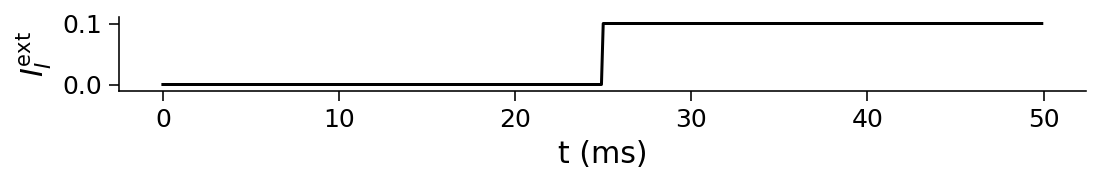

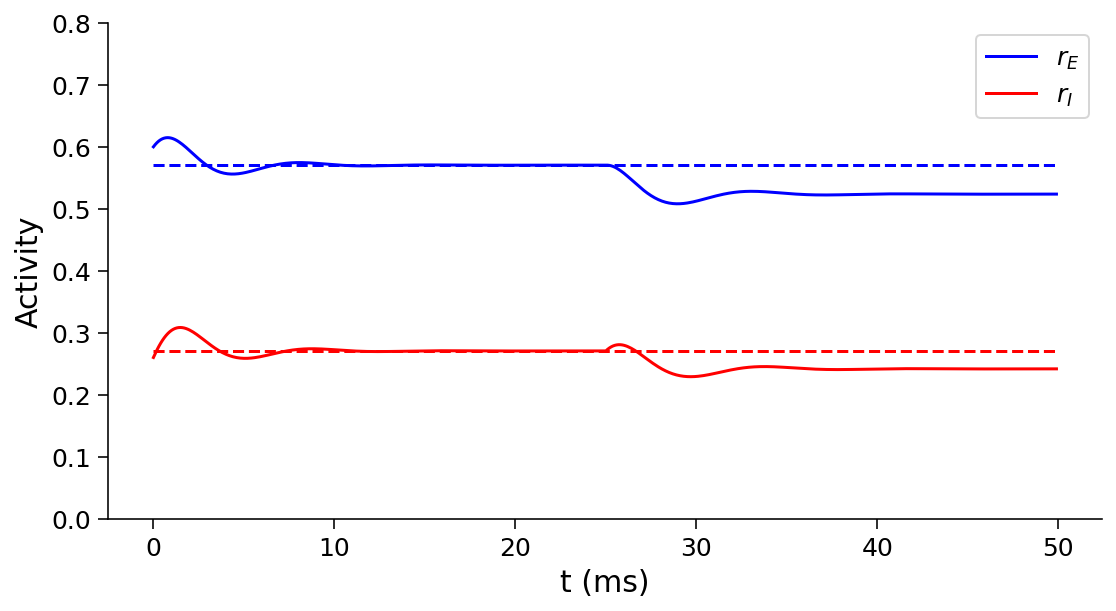

In [35]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

pars = default_pars(T=50., dt=0.1)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['tau_I'] = 0.8


def ISN_I_perturb(dI=0.1):
  Lt = len(pars['range_t'])
  pars['I_ext_I'] = np.zeros(Lt)
  pars['I_ext_I'][int(Lt / 2):] = dI

  pars['rE_init'], pars['rI_init'] = 0.6, 0.26
  rE, rI = simulate_wc(**pars)

  plt.figure(figsize=(8, 1.5))

  plt.plot(pars['range_t'], pars['I_ext_I'], 'k')
  plt.xlabel('t (ms)')
  plt.ylabel(r'$I_I^{\mathrm{ext}}$')
  plt.ylim(pars['I_ext_I'].min() - 0.01, pars['I_ext_I'].max() + 0.01)
  plt.show()

  plt.figure(figsize=(8, 4.5))
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rE[int(Lt / 2) - 1] * np.ones(Lt), 'b--')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.plot(pars['range_t'], rI[int(Lt / 2) - 1] * np.ones(Lt), 'r--')
  plt.ylim(0, 0.8)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.show()


_ = widgets.interact(ISN_I_perturb, dI=(-0.2, 0.21, .05))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_a6e499ee.py)



---
# Bonus 3: Fixed point and working memory

The input into the neurons measured in the experiment is often very noisy ([links](http://www.scholarpedia.org/article/Stochastic_dynamical_systems)). Here, the noisy synaptic input current is modeled as an Ornstein-Uhlenbeck (OU)process, which has been discussed several times in the previous tutorials.


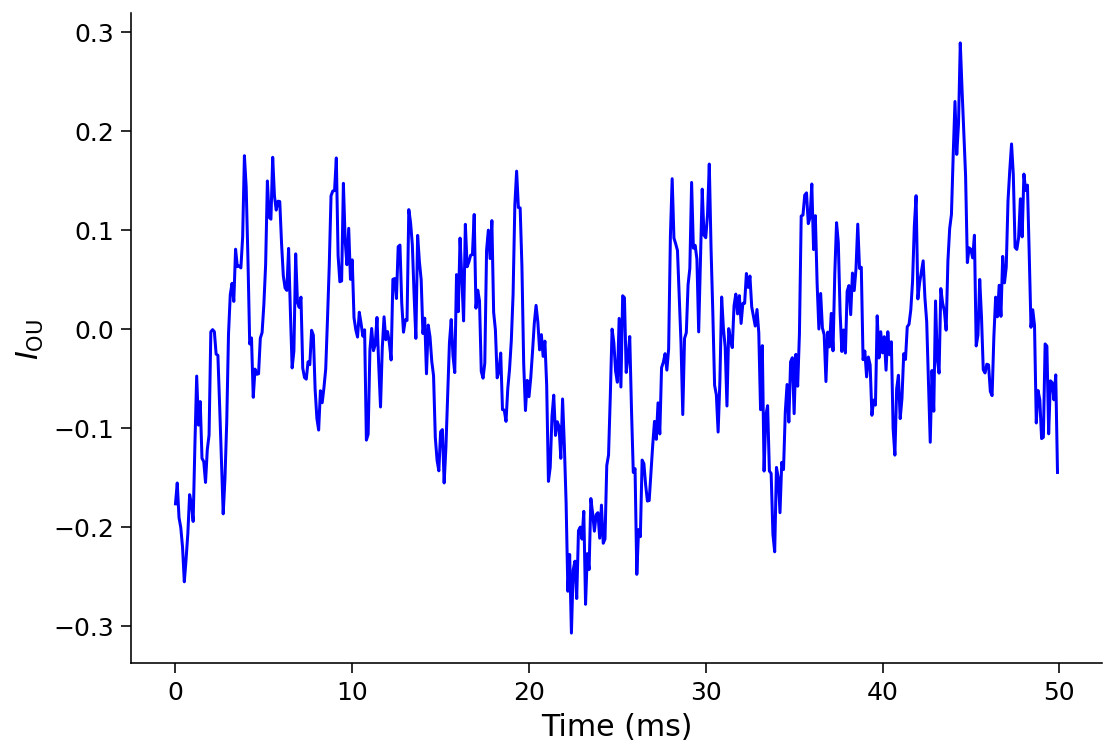

In [37]:
# @markdown Make sure you execute this cell to enable the function my_OU and plot the input current!


def my_OU(pars, sig, myseed=False):
  """
  Expects:
  pars       : parameter dictionary
  sig        : noise amplitute
  myseed     : random seed. int or boolean

  Returns:
  I          : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
      I_ou[it+1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])
  return I_ou


pars = default_pars(T=50)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=2020)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], I_ou, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()



With the default parameters, the system fluctuates around a resting state with the noisy input.


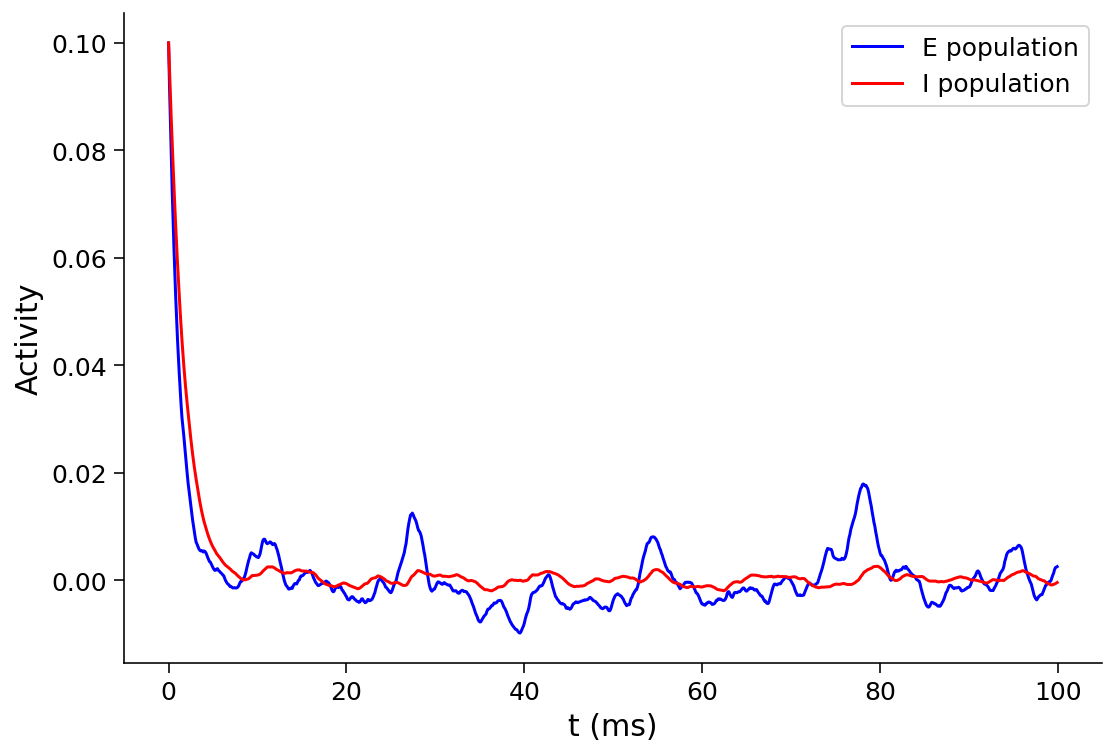

In [38]:
# @markdown Execute this cell to plot activity with noisy input current
pars = default_pars(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=20201)
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=20202)

pars['rE_init'], pars['rI_init'] = 0.1, 0.1
rE, rI = simulate_wc(**pars)

plt.figure(figsize=(8, 5.5))
ax = plt.subplot(111)
ax.plot(pars['range_t'], rE, 'b', label='E population')
ax.plot(pars['range_t'], rI, 'r', label='I population')
ax.set_xlabel('t (ms)')
ax.set_ylabel('Activity')
ax.legend(loc='best')
plt.show()

## Interactive Demo: Short pulse induced persistent activity
Then, let's use a brief 10-ms positive current to the E population when the system is at its equilibrium. When this amplitude (SE below) is sufficiently large, a persistent activity is produced that outlasts the transient input. What is the firing rate of the persistent activity, and what is the critical input strength? Try to understand the phenomena from the above phase-plane analysis.

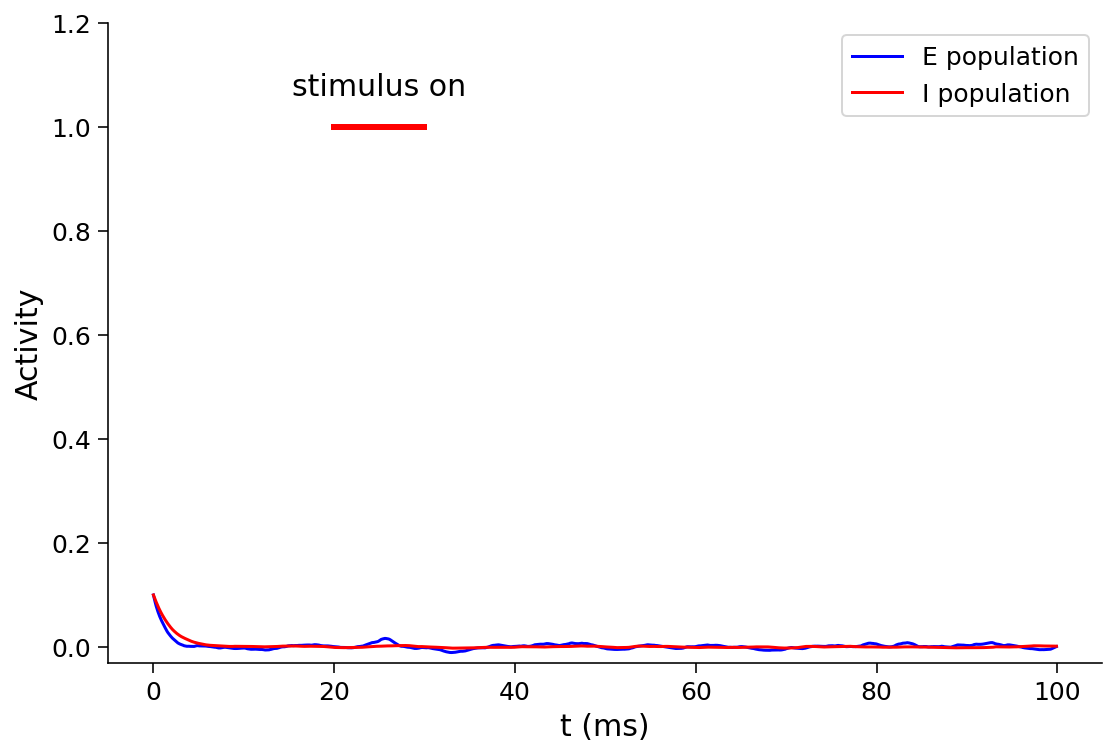

In [39]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def my_inject(pars, t_start, t_lag=10.):
  """
  Expects:
  pars       : parameter dictionary
  t_start    : pulse starts [ms]
  t_lag      : pulse lasts  [ms]

  Returns:
  I          : extra pulse time
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  I = np.zeros(Lt)

  # pulse timing
  N_start = int(t_start / dt)
  N_lag = int(t_lag / dt)
  I[N_start:N_start + N_lag] = 1.

  return I


pars = default_pars(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=2021)
pars['rE_init'], pars['rI_init'] = 0.1, 0.1

# pulse
I_pulse = my_inject(pars, t_start=20., t_lag=10.)
L_pulse = sum(I_pulse > 0.)


def WC_with_pulse(SE=0.):
  pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=2022)
  pars['I_ext_E'] += SE * I_pulse

  rE, rI = simulate_wc(**pars)

  plt.figure(figsize=(8, 5.5))
  ax = plt.subplot(111)
  ax.plot(pars['range_t'], rE, 'b', label='E population')
  ax.plot(pars['range_t'], rI, 'r', label='I population')

  ax.plot(pars['range_t'][I_pulse > 0.], 1.0*np.ones(L_pulse), 'r', lw=3.)
  ax.text(25, 1.05, 'stimulus on', horizontalalignment='center',
          verticalalignment='bottom')
  ax.set_ylim(-0.03, 1.2)
  ax.set_xlabel('t (ms)')
  ax.set_ylabel('Activity')
  ax.legend(loc='best')
  plt.show()


_ = widgets.interact(WC_with_pulse, SE=(0.0, 1.0, .05))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_89017acc.py)



Explore what happened when a second, brief current is applied to the inhibitory population. 